In [1]:
%matplotlib inline
import argparse
import glob
import os
import sys
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from networks.drn_seg import DRNSeg
from utils.tools import *
from utils.visualize import *
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

In [2]:
model_path = './japanese_model3.pth'
gpu_id = 0
no_crop = True

# Loading the model
if torch.cuda.is_available():
    print(f'cuda:{gpu_id} is available')
    device = 'cuda:{}'.format(gpu_id)
else:
    print(f'cuda is not available')
    device = 'cpu'

model = DRNSeg(2)
state_dict = torch.load(model_path, map_location=device)
# model.load_state_dict(state_dict['model'])
model.load_state_dict(state_dict)
model.to(device)
model.eval()

cuda is not available


DRNSeg(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(3

In [3]:
# train_original_path = './data/japansese_train/reference/*'
train_original_path = './data/japansese_train/reference'
train_modified_path = './data/japansese_train/modified/*'
train_modified_path2 = './data/japansese_train/modified2/*'
# originals = glob.glob(train_original_path)
modifieds = glob.glob(train_modified_path)
modifieds2 = glob.glob(train_modified_path2)
modifieds = modifieds + modifieds2
# originals.sort()
modifieds.sort()
modifieds.reverse()

In [4]:
len(modifieds)

422

In [5]:
# filenameを確認
# for o, m in zip(originals, modifieds):
#     o_name = os.path.basename(o)
#     m_name = os.path.basename(m)
#     if o_name != m_name:
#         print(o_name)
#         print(m_name)
#     else:
#         print("good")

In [6]:
learning_rate = 2e-3
batch_size = 5
epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred_flow, y_flow):
        loss0 = 0
        loss1 = 0
        sum_a0 = 0
        sum_a1 = 0
        h, w, _ = pred_flow.shape
        for i in range(h):
            for j in range(w):
                a0 = torch.exp(-torch.abs(y_flow[i][j][0]))
                a1 = torch.exp(-torch.abs(y_flow[i][j][1]))
                sum_a0 += a0
                sum_a1 += a1
#                 loss0 += a0 * (((pred_flow[i][j][0] - y_flow[i][j][0]) ** 2) ** 0.5)
#                 loss1 += a1 * (((pred_flow[i][j][1] - y_flow[i][j][1]) ** 2) ** 0.5)
                loss0 += a0 * (((pred_flow[i][j][0] - y_flow[i][j][0]) ** 2))
                loss1 += a1 * (((pred_flow[i][j][1] - y_flow[i][j][1]) ** 2))
        loss = (loss0 / sum_a0) + (loss1 / sum_a1)
        return loss

In [8]:
def _train(model, original_img_path, modified_img_path):
    # Data preprocessing
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    im_w, im_h = Image.open(modified_img_path).size
    if no_crop:
        face = Image.open(modified_img_path).convert('RGB')
        original_face = Image.open(original_img_path).convert('RGB')
    else:
        faces = face_detection(modified_img_path, verbose=False)
        if len(faces) == 0:
            print("no face detected by dlib, exiting")
            sys.exit()
        face, box = faces[0]
    face = resize_shorter_side(face, 400)[0]
    original_face = resize_shorter_side(original_face, 400)[0]
    face_tens = tf(face).to(device)

    # predict flow
    flow = model(face_tens.unsqueeze(0))[0]


    # calc y_flow
    _, _h, _w = flow.shape
    resized_face = face.resize((_w, _h), Image.BICUBIC)
    resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
    resized_face_np = np.asarray(resized_face)
    resized_original_face_np = np.asarray(resized_original_face)
    resized_face_gray = cv2.cvtColor(resized_face_np,cv2.COLOR_BGR2GRAY)
    resized_original_face_gray = cv2.cvtColor(resized_original_face_np,cv2.COLOR_BGR2GRAY)
    y_flow = cv2.calcOpticalFlowFarneback(resized_face_gray,resized_original_face_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_flow_tensor = torch.from_numpy(y_flow)
    y_flow_reshaped = y_flow_tensor.reshape(flow.shape)

    # cals loss
    custom_loss = CustomLoss()
    loss = custom_loss(flow, -y_flow_reshaped)
    return loss

In [25]:
# def train(model, originals, modifieds, batch_size, epochs, optimizer):
#     if len(originals) != len(modifieds):
#         raise Exception('error')
#     loop_num = len(originals) // batch_size + 1
#     for _ in tqdm(range(epochs)):
#         count = 0
#         for _ in tqdm(range(loop_num)):
#             loss = 0
#             for _ in range(batch_size):
#                 original = originals[count % len(originals)]
#                 modified = modifieds[count % len(modifieds)]
#                 loss += _train(model, original, modified)
#                 count += 1
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#     return model

In [9]:
def train(model, original_path, modifieds, epochs, optimizer):
    for _ in tqdm(range(epochs)):
        for i in tqdm(range(len(modifieds))):
#             original = originals[i]
            modified = modifieds[i]
            modified_file_name = os.path.basename(modified)
            original = os.path.join(original_path, modified_file_name)
            loss = _train(model, original, modified)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

In [10]:
train(model, train_original_path, modifieds, epochs, optimizer)

  0%|          | 0/422 [00:00<?, ?it/s]/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_29681/1107583997.py:28: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_29681/1107583997.py:29: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)

  0%|          | 0/100 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [54]:
# original_img_path = './data/japansese_train/reference/a58.jpg'
# modified_img_path = './data/japansese_train/modified/a58.jpg'
original_img_path = './examples/natsuki_kataoka_original.png'
modified_img_path = './examples/natsuki_kataoka_modified.png'
dest_folder = './out/anzu'
if True:
# Data preprocessing
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    im_w, im_h = Image.open(modified_img_path).size
    if no_crop:
        face = Image.open(modified_img_path).convert('RGB')
        original_face = Image.open(original_img_path).convert('RGB')
    else:
        faces = face_detection(modified_img_path, verbose=False)
        if len(faces) == 0:
            print("no face detected by dlib, exiting")
            sys.exit()
        face, box = faces[0]
    face = resize_shorter_side(face, 400)[0]
    original_face = resize_shorter_side(original_face, 400)[0]
    face_tens = tf(face).to(device)
    
    
   

    # Warping field prediction
    with torch.no_grad():
        flow = model(face_tens.unsqueeze(0))
        _flow = flow
        flow = flow[0].cpu().numpy()
    
    
     # calc y_flow
    _, _h, _w = flow.shape
    resized_face = face.resize((_w, _h), Image.BICUBIC)
    resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
    resized_face_np = np.asarray(resized_face)
    resized_original_face_np = np.asarray(resized_original_face)
    resized_face_gray = cv2.cvtColor(resized_face_np,cv2.COLOR_BGR2GRAY)
    resized_original_face_gray = cv2.cvtColor(resized_original_face_np,cv2.COLOR_BGR2GRAY)
    y_flow = cv2.calcOpticalFlowFarneback(resized_face_gray,resized_original_face_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_flow_tensor = torch.from_numpy(y_flow)
    y_flow_reshaped = y_flow_tensor.reshape(flow.shape)
    flow = np.transpose(flow, (1, 2, 0))
    h, w, _ = flow.shape
    
    # Undoing the warps
    print(f"w is {w} and h is {h}")
    modified = face.resize((w, h), Image.BICUBIC)
    modified_np = np.asarray(modified)
    reverse_np = warp(modified_np, flow)
    reverse = Image.fromarray(reverse_np)
    flow_magn = np.sqrt(flow[:, :, 0] **2 + flow[:, :, 1]**2)
    heatmapped = Image.fromarray(get_heatmap_cv(modified_np, flow_magn, 7))
#     modified_gray = cv2.cvtColor(modified_np,cv2.COLOR_BGR2GRAY)
#     reverse_gray = cv2.cvtColor(reverse_np,cv2.COLOR_BGR2GRAY)
#     cv_flow = cv2.calcOpticalFlowFarneback(modified_gray,reverse_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_reverse_np = warp(modified_np, - y_flow)
    y_reverse = Image.fromarray(y_reverse_np)
    y_flow_magn = np.sqrt(y_flow[:, :, 0]**2 + y_flow[:, :, 1]**2)
    y_heatmapped = Image.fromarray(get_heatmap_cv(modified_np, y_flow_magn, 7))

w is 400 and h is 512


/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_2659/771097215.py:40: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_2659/771097215.py:41: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_2659/771097215.py:54: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  modified = face.resize((w, h), Image.BICUBIC)


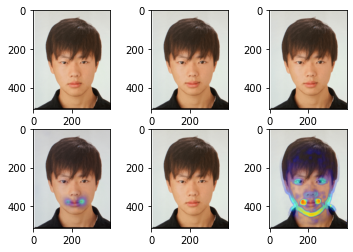

In [55]:
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
ax1.imshow(np.array(resized_original_face))
ax2.imshow(np.array(modified))
ax3.imshow(np.array(reverse))
ax4.imshow(np.array(heatmapped))
ax5.imshow(np.array(y_reverse))
ax6.imshow(np.array(y_heatmapped))
# ax5.imshow(np.array())

In [30]:
model.state_dict()

OrderedDict([('base.0.weight',
              tensor([[[[ 3.4754e-02, -4.1213e-02, -5.2262e-02,  ...,  3.3527e-02,
                          5.0736e-02,  3.4269e-02],
                        [-2.1376e-02, -1.0041e-01, -9.2806e-02,  ...,  6.1725e-02,
                          1.0887e-01,  8.8536e-02],
                        [-9.4190e-02, -1.8583e-01, -1.5668e-01,  ...,  1.3399e-01,
                          2.2771e-01,  2.1040e-01],
                        ...,
                        [-2.2578e-01, -3.5802e-01, -2.9641e-01,  ...,  1.6701e-01,
                          3.5305e-01,  3.9016e-01],
                        [-1.7028e-01, -2.8975e-01, -2.5930e-01,  ...,  1.2572e-01,
                          2.9423e-01,  3.1484e-01],
                        [-9.5551e-02, -1.9385e-01, -1.7925e-01,  ...,  8.0008e-02,
                          1.7984e-01,  1.9419e-01]],
              
                       [[-3.3721e-02, -8.9080e-02, -7.6277e-02,  ...,  2.6722e-02,
                          5.345

In [140]:
model.state_dict()

OrderedDict([('base.0.weight',
              tensor([[[[ 3.5191e-02, -4.0785e-02, -5.1805e-02,  ...,  3.3972e-02,
                          5.1178e-02,  3.4719e-02],
                        [-2.0961e-02, -1.0000e-01, -9.2368e-02,  ...,  6.2150e-02,
                          1.0929e-01,  8.8972e-02],
                        [-9.3780e-02, -1.8543e-01, -1.5625e-01,  ...,  1.3441e-01,
                          2.2813e-01,  2.1085e-01],
                        ...,
                        [-2.2536e-01, -3.5760e-01, -2.9596e-01,  ...,  1.6746e-01,
                          3.5351e-01,  3.9064e-01],
                        [-1.6983e-01, -2.8930e-01, -2.5882e-01,  ...,  1.2619e-01,
                          2.9470e-01,  3.1533e-01],
                        [-9.5088e-02, -1.9339e-01, -1.7875e-01,  ...,  8.0491e-02,
                          1.8032e-01,  1.9469e-01]],
              
                       [[-3.3308e-02, -8.8653e-02, -7.5825e-02,  ...,  2.7154e-02,
                          5.386

In [56]:
japanese_model_path = 'japanese_model4.pth'
torch.save(model.state_dict(), japanese_model_path)